In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

### Load data

In [2]:
df = pd.read_csv("Data/data_daily/dataset_daily.csv")
df.head(2)

,Date,Open_USD_CHF,Open_CHF_EUR,Open_CHF_GBP,Open_CHF_JPY,Open_CHF_CAD,Open_BondCH1m,Open_BondCH2y,Open_BondCH10y,Open_SMI,Open_USD_JPY,Open_USD_EUR,Open_USD_GBP,Open_USD_CAD,Open_BondUS1m,Open_BondUS2y,Open_BondUS10y,Open_SP500
0,2001-12-27,1.6886,0.6723,0.4071,77.46,0.9477,1.68,2.011,3.460,6392.1,130.82,1.1356,0.6876,1.6010,1.751,3.307,5.072,1149.4
1,2001-12-28,1.6776,0.6745,0.4106,78.48,0.9520,1.68,2.059,3.474,6430.6,131.68,1.1319,0.6887,1.5981,1.720,3.169,5.113,1157.1


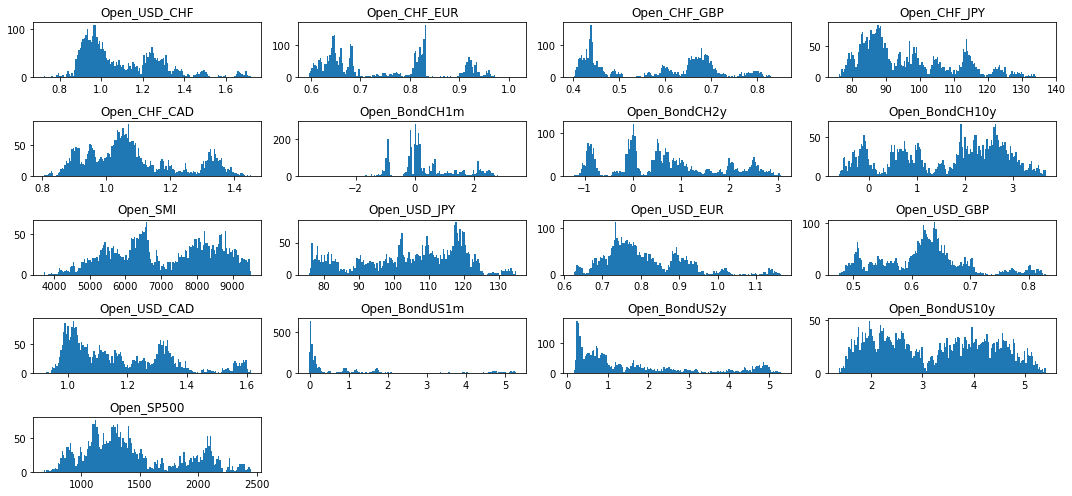

In [3]:
data = []
for i in df.columns[1:]:
    data.append(df[i])

fig = plt.figure(figsize=(15, 7))

name  = df.columns[1:]

for i in range(len(data)):   
    plt.subplot(5, 4,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

205
66
42
Shape:             
X train     (2708, 4, 17), y train     (2708, 17)            
X train val (301, 4, 17) , y train val (301, 17)             
X test      (532, 4, 17) , y test      (532, 17)
205
66
42
Shape:             
X train     (2708, 4, 17), y train     (2708, 17)            
X train val (301, 4, 17) , y train val (301, 17)             
X test      (532, 4, 17) , y test      (532, 17)


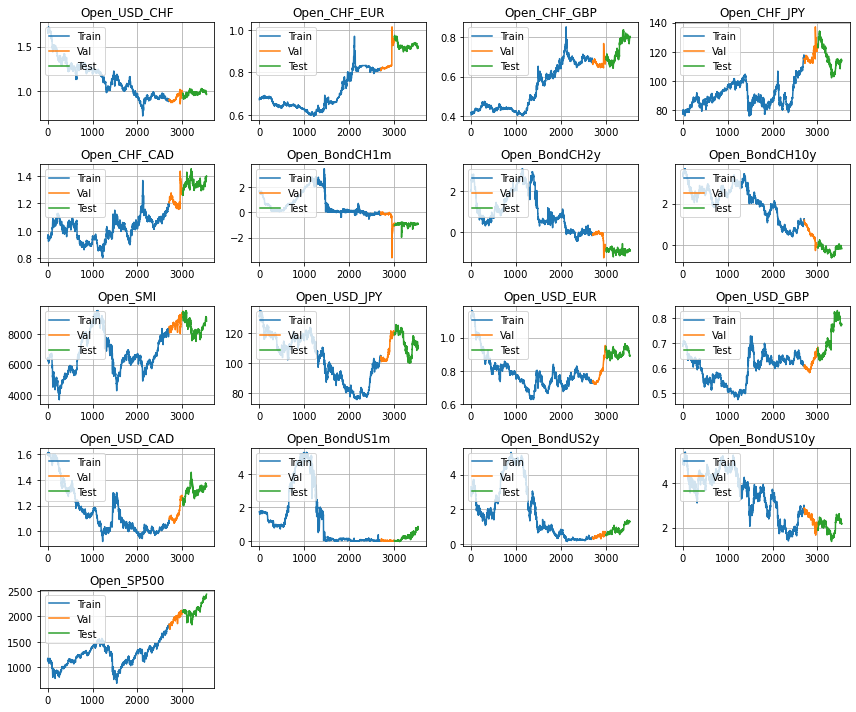

In [4]:
device = 'cpu'
LOOKBACK = 4

train_x, val_x, test_x, train_y, val_y, test_y, norm, price= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=True,
  span_trend_=4,
  span_back_trend_= 0,
  tresh=0.0,
  norm_=True,
  fraction_val_=0.1,
  fraction_test_=0.15)

_, _, _, train_y_reg, val_y_reg, test_y_reg, norm, price= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=False,
  span_trend_=4,
  norm_=True,
  fraction_val_=0.1,
  fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(5, 4,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

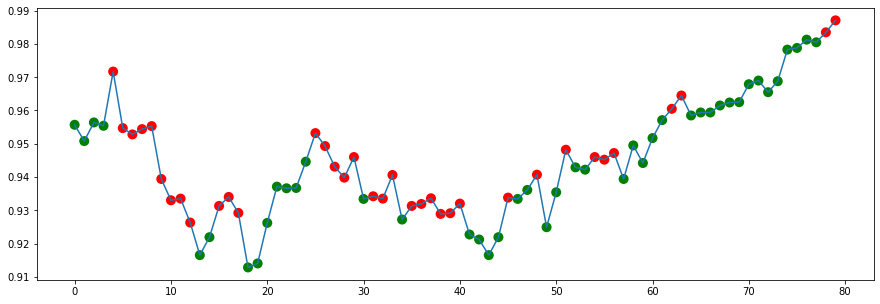

In [5]:
end = 80#300 l2
colors = {0:'red', 1:'green'}
plt.figure(figsize=(15,5))


plt.scatter(np.arange(end), price[l2:l2+ end ], c=pd.Series(test_y[:end,0]).map(colors).values, s=100, lw=0)
plt.plot(np.arange(end), price[l2:l2+ end ])

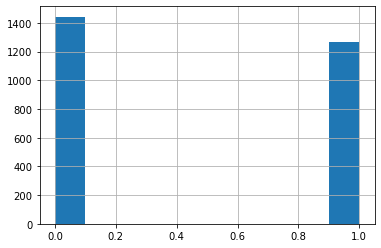

In [6]:
plt.hist(train_y[:,0], )
plt.grid()
plt.show()

In [7]:

train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y_reg[np.isnan(train_y_reg)] = 0.5 
val_y_reg[np.isnan(val_y_reg)] = 0.5
test_y_reg[np.isnan(test_y_reg)] = 0.5

train_y_reg[np.isnan(train_y_reg)] , val_y_reg[np.isnan(val_y_reg)], test_y_reg[np.isnan(test_y_reg)] 

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

In [8]:
train_x_fin  = pp.add_label_data(train_x, train_y)
val_x_fin  = pp.add_label_data(val_x, val_y)
test_x_fin  = pp.add_label_data(test_x, test_y)

span = train_x.shape[1]

train_y_fin  = train_y_reg[span:]
val_y_fin  = val_y_reg[span:]
test_y_fin  = test_y_reg[span:]

train_y_fin.shape,val_y_fin.shape, test_y_fin.shape, train_x_fin.shape

((2704, 17), (297, 17), (528, 17), (2704, 4, 34))

# Price prediction 

### GRU 1-feature

In [74]:
model_gru_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_1.to(device)
model_gru_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


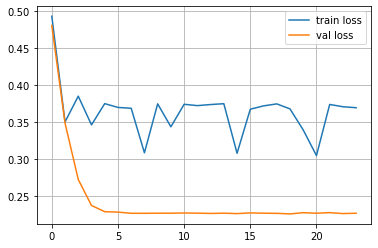

In [75]:
lr= 0.001
num_epochs= 100

train_loss, val_loss = pl.train(
    model=model_gru_1,
    train_x_ = train_x[:,:,0].reshape(-1, LOOKBACK, 1),
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x[:,:,0].reshape(-1, LOOKBACK, 1),
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=0.001,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [76]:
outputs_gru_1, targets, MSE = pl.evaluate(model_gru_1, test_x[:,:,0].reshape(-1, LOOKBACK,1), test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_gru_1 = pp.min_max_norm_inverse(outputs_gru_1.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,) , tuple_min_max_=tuple_min_max)
REAL_MSE_gru_1 = np.mean((outputs_gru_1-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_1:0.08f}")
REAL_ACC_gru_1 = pl.direction_accuracy(outputs_gru_1, t)
print(f"ACC {REAL_ACC_gru_1:0.03f}") 0.000169

MSE:  0.23508
REAL MSE: 0.00001603
ACC 0.501


### GRU 5-feature

In [32]:
model_gru_5 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=5,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_5.to(device)
model_gru_5

GRU_base(
  (gru): GRU(5, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


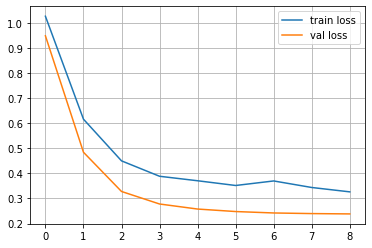

In [33]:
lr= 0.001
num_epochs= 100
train_loss, val_loss = pl.train(
    model=model_gru_5,
    train_x_ = train_x,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/10)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [62]:
outputs_gru_5, targets, MSE = pl.evaluate(model_gru_5, test_x, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_gru_5 = pp.min_max_norm_inverse(outputs_gru_5.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,) , tuple_min_max_=tuple_min_max)

REAL_MSE_gru_5 = np.mean((outputs_gru_5-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_5:0.08f}")
REAL_ACC_gru_5 = pl.direction_accuracy(outputs_gru_5, t)
print(f"ACC: {REAL_ACC_gru_5:0.03f}")



MSE:  0.24598
REAL MSE: 0.00001708
ACC: 0.520


### GRU + Auto-Encoder 1-feature 

In [38]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.load_state_dict(torch.load('Helper/model/model_autoenc_1.pth'))
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

In [39]:
model_gru_autoenc_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_1.to(device)
model_gru_autoenc_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


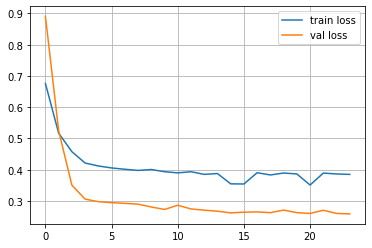

In [40]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp1.to(device).float())
train_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp2.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

lr= 0.001
num_epochs= 100 

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [63]:
inp3 = torch.from_numpy(test_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp3.to(device).float())
test_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

outputs_gru_autoenc_1, targets, MSE = pl.evaluate(model_gru_autoenc_1, test_x_smooth, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_gru_autoenc_1 = pp.min_max_norm_inverse(outputs_gru_autoenc_1.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

REAL_MSE_gru_autoenc_1 = np.mean((outputs_gru_autoenc_1-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_autoenc_1:0.08f}") 

REAL_ACC_gru_autoenc_1 = pl.direction_accuracy(outputs_gru_autoenc_1, t)
print(f"ACC: {REAL_ACC_gru_autoenc_1:0.03f}")

MSE:  0.25259
REAL MSE: 0.00001802
ACC: 0.496


### Dense + latent space Auto-Encoder 1-feature 

In [42]:
model_dense_autoenc_1 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=3,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_1.to(device)
model_dense_autoenc_1

Dense(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 100/100 [00:03<00:00, 30.04it/s]


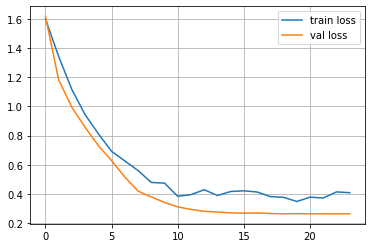

In [43]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

lr= 0.001
num_epochs= 100 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=0.001,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [64]:
inp3 = torch.from_numpy(test_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp3.to(device).float(), return_latent=True)
test_x_smooth = latent.cpu().detach().numpy().reshape(-1,3)

outputs_dense_autoenc_1, targets, MSE = pl.evaluate(model_dense_autoenc_1, test_x_smooth, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_dense_autoenc_1 = pp.min_max_norm_inverse(outputs_dense_autoenc_1.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

REAL_MSE_dense_autoenc_1 = np.mean((outputs_dense_autoenc_1-t)**2)
print(f"REAL MSE: {REAL_MSE_dense_autoenc_1:0.08f}")

REAL_ACC_dense_autoenc_1 = pl.direction_accuracy(outputs_dense_autoenc_1, t)
print(f"ACC: {REAL_ACC_dense_autoenc_1:0.03f}")

MSE:  0.24842
REAL MSE: 0.00001805
ACC: 0.489


### GRU + Auto-Encoder 17-feature 

In [9]:
model_autoenc_17 = ml.auto_encoder(input_size=17*2,
    nb_channel_conv=8)
model_autoenc_17.load_state_dict(torch.load('Helper/model/model_autoenc_17.pth'))
model_autoenc_17.to(device)
model_autoenc_17

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(34, 8, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv3): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv1_t): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv2_t): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv3_t): ConvTranspose1d(8, 34, kernel_size=(2,), stride=(1,))
)

In [10]:
model_gru_autoenc_17 = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size=17*2,
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_17.load_state_dict(torch.load('Helper/model/model_trend_17.pth'))
model_gru_autoenc_17.to(device)
model_gru_autoenc_17

GRU_base(
  (gru): GRU(34, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [11]:
model_autoenc_17.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x_fin,1,2))
out = model_autoenc_17(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x_fin,1,2))
out = model_autoenc_17(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

model_gru_autoenc_17.eval()

inp1 = torch.from_numpy(train_x_smooth)
train_x_trend = model_gru_autoenc_17(inp1.to(device).float()).cpu().detach().numpy()

inp2 = torch.from_numpy(val_x_smooth)
val_x_trend = model_gru_autoenc_17(inp2.to(device).float()).cpu().detach().numpy()

#### Train

In [203]:
model_gru_autoenc_17_reg = ml.GRU_trend(
        hidden_size=8,
        num_layers=3,
        input_size=17*2,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)

model_gru_autoenc_17_reg.to(device)
model_gru_autoenc_17_reg

GRU_trend(
  (gru): GRU(34, 8, num_layers=3, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=9, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

  0%|          | 2/500 [00:01<04:08,  2.00it/s]

Epoch: 2/500
MSE = [train loss mean :  7924.56592533] , [val loss mean:  940.28112793, MSE (last) 93891.35742%]


  1%|          | 4/500 [00:01<04:03,  2.04it/s]

Epoch: 4/500
MSE = [train loss mean :  7921.96646746] , [val loss mean:  945.32626343, MSE (last) 94584.57031%]


  1%|          | 6/500 [00:02<04:00,  2.05it/s]

Epoch: 6/500
MSE = [train loss mean :  7909.70187557] , [val loss mean:  939.56994629, MSE (last) 93652.83813%]


  2%|▏         | 8/500 [00:03<04:00,  2.04it/s]

Epoch: 8/500
MSE = [train loss mean :  7907.87845472] , [val loss mean:  935.44250488, MSE (last) 93801.06812%]


  2%|▏         | 10/500 [00:04<03:54,  2.09it/s]

Epoch: 10/500
MSE = [train loss mean :  7749.33515894] , [val loss mean:  928.82345581, MSE (last) 92613.97095%]


  2%|▏         | 12/500 [00:05<03:52,  2.10it/s]

Epoch: 12/500
MSE = [train loss mean :  7853.00688019] , [val loss mean:  929.71746826, MSE (last) 93101.48926%]


  3%|▎         | 14/500 [00:06<03:50,  2.11it/s]

Epoch: 14/500
MSE = [train loss mean :  7678.53336159] , [val loss mean:  923.77038574, MSE (last) 92054.51660%]


  3%|▎         | 16/500 [00:07<03:49,  2.11it/s]

Epoch: 16/500
MSE = [train loss mean :  7791.14702095] , [val loss mean:  926.46365356, MSE (last) 92588.97095%]


  4%|▎         | 18/500 [00:08<03:47,  2.12it/s]

Epoch: 18/500
MSE = [train loss mean :  7629.22750262] , [val loss mean:  920.81735229, MSE (last) 91658.20312%]


  4%|▍         | 20/500 [00:09<03:46,  2.12it/s]

Epoch: 20/500
MSE = [train loss mean :  7603.10167335] , [val loss mean:  913.75918579, MSE (last) 91452.58179%]


  4%|▍         | 22/500 [00:10<03:45,  2.12it/s]

Epoch: 22/500
MSE = [train loss mean :  7513.76182785] , [val loss mean:  915.19097900, MSE (last) 91778.97339%]


  5%|▍         | 24/500 [00:11<03:44,  2.12it/s]

Epoch: 24/500
MSE = [train loss mean :  7550.64979495] , [val loss mean:  915.22418213, MSE (last) 91288.03101%]


  5%|▌         | 26/500 [00:12<03:43,  2.13it/s]

Epoch: 26/500
MSE = [train loss mean :  7431.63309811] , [val loss mean:  915.60256958, MSE (last) 91583.13599%]


  6%|▌         | 28/500 [00:13<03:42,  2.12it/s]

Epoch: 28/500
MSE = [train loss mean :  7400.18112999] , [val loss mean:  915.80850220, MSE (last) 91676.58081%]


  6%|▌         | 30/500 [00:14<03:41,  2.12it/s]

Epoch: 30/500
MSE = [train loss mean :  7420.32319026] , [val loss mean:  917.86834717, MSE (last) 91983.82568%]


  6%|▌         | 30/500 [00:14<03:51,  2.03it/s]

916.2518513997396 < 916.5178466796875
Epoch: 31/500
MSE = [train loss mean :  7477.90521568] , [val loss mean:  917.53689575, MSE (last) 91523.55347%]


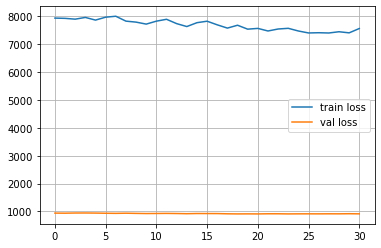

In [205]:
lr= 0.0001
num_epochs= 500

train_loss, val_loss = pl.train_with_trend(
    model=model_gru_autoenc_17_reg,
    train_x_ = train_x_smooth,
    train_x_trend_ = train_x_trend, 
    train_y_ = train_y_fin[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_x_trend_ = val_x_trend, 
    val_y_= val_y_fin[:,0].reshape(-1,1),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1,
    lambda_=10)
'''  
chunksize= int(num_epochs/3)#906.93060875
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()
'''
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.grid()
plt.show() #885.4



In [209]:

inp3 = torch.from_numpy(np.swapaxes(test_x_fin,1,2))
out = model_autoenc_17(inp3.to(device).float())
test_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)


inp3 = torch.from_numpy(test_x_smooth)
test_x_trend = model_gru_autoenc_17(inp3.to(device).float()).cpu().detach().numpy()

outputs_gru_autoenc_17, targets, MSE = pl.evaluate(model_gru_autoenc_17_reg, test_x_smooth, test_y_fin[:,0].reshape(-1,1), device='cpu', x_trend_=test_x_trend) 

tuple_min_max= norm[2]
outputs_gru_autoenc_17 = pp.min_max_norm_inverse(outputs_gru_autoenc_17.reshape(-1,), tuple_min_max_=tuple_min_max, span_=span) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max, span_=span)

REAL_MSE_gru_autoenc_17 = np.mean((outputs_gru_autoenc_17-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_autoenc_17:0.08f}")

REAL_ACC_gru_autoenc_17 = pl.direction_accuracy(outputs_gru_autoenc_17, t)
print(f"ACC: {REAL_ACC_gru_autoenc_17:0.03f}") # 0.00001621 0.00003256 0.00014080

MSE:  1.04565
REAL MSE: 0.00005540
ACC: 0.586


### Dense + latent space Auto-Encoder 5-feature 

In [121]:
model_dense_autoenc_5 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=15,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_5.to(device)
model_dense_autoenc_5

Dense(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [122]:
model_autoenc_5.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out, latent = model_autoenc_5(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_5(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

lr= 0.001
num_epochs= 100 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_5,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

NameError: name 'model_autoenc_5' is not defined

In [66]:
inp3 = torch.from_numpy(np.swapaxes(test_x,1,2))
out, latent = model_autoenc_5(inp3.to(device).float(), return_latent=True)
test_x_smooth = latent.cpu().detach().numpy().reshape(-1,15)

outputs_dense_autoenc_5, targets, MSE = pl.evaluate(model_dense_autoenc_5, test_x_smooth, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_dense_autoenc_5 = pp.min_max_norm_inverse(outputs_dense_autoenc_5.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

REAL_MSE_dense_autoenc_5 = np.mean((outputs_dense_autoenc_5-t)**2)
print(f"REAL MSE: {REAL_MSE_dense_autoenc_5:0.08f}")

REAL_ACC_dense_autoenc_5 = pl.direction_accuracy(outputs_dense_autoenc_5, t)
print(f"ACC {REAL_ACC_dense_autoenc_5:0.03f}")

MSE:  0.26372
REAL MSE: 0.00001905
ACC 0.524


# Result 

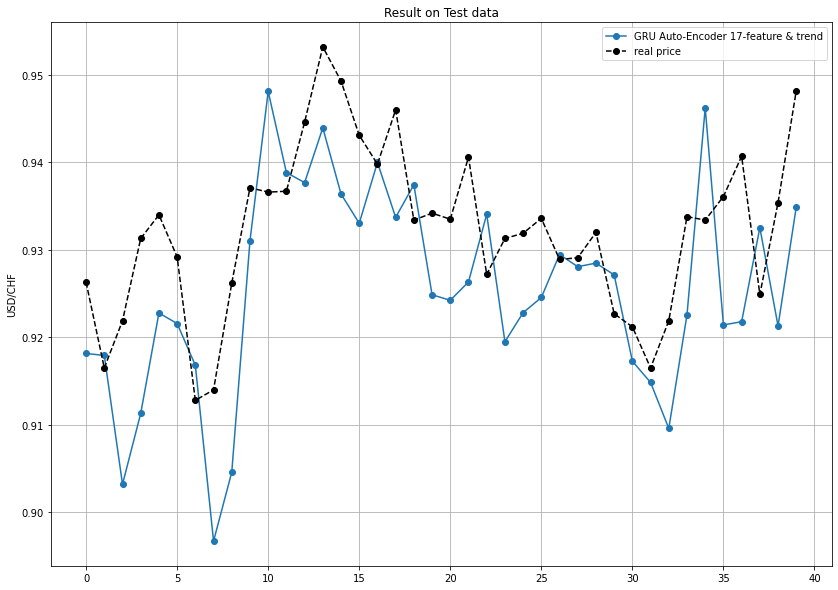

In [210]:
range_ = range(7,47)#range(7,17)
range_2 = range_#range(7,17)
plt.figure(figsize=(14, 10))
plt.title("Result on Test data")
#plt.plot(outputs_gru_1[range_], "-o", label="GRU 1-feature")
#plt.plot(outputs_gru_5[range_], "-o", label="GRU 5-features")
#plt.plot(outputs_gru_autoenc_1[range_], "-o", label="GRU Auto-Encoder 1-feature")
#plt.plot(outputs_dense_autoenc_1[range_], "-o", label="Dense latent space Auto-Encoder 1-feature")
plt.plot(outputs_gru_autoenc_17[range_], "-o", label="GRU Auto-Encoder 17-feature & trend")
#plt.plot(outputs_dense_autoenc_5[range_], "-o", label="Dense latent space Auto-Encoder 5-feature")
plt.plot(t[range_2], "--o", c='k',label="real price")
plt.grid()
plt.ylabel("USD/CHF")
plt.legend()
plt.show()

In [186]:
label[1] > label[0]

False

price =  0.9553 [ TIME:  3  ]
gain =  -0.019591841672772836 % [ TIME:  4  ]
portfolio=  0.9804081583272272
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.9219 [ TIME:  9  ]
gain =  0.010087972122790001 % [ TIME:  11  ]
portfolio=  0.9904961304500172
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.914 [ TIME:  14  ]
gain =  0.021654603227571068 % [ TIME:  17  ]
portfolio=  1.0121507336775881
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.9446 [ TIME:  19  ]
gain =  0.006079340143976486 % [ TIME:  20  ]
portfolio=  1.0182300738215646
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.9431 [ TIME:  22  ]
gain =  -0.006486359293818245 % [ TIME:  23  ]
portfolio=  1.0117437145277464
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.946 [ TIME:  24  ]
gain =  -0.01627706115221983 % [ TIME:  25  ]
portfolio=  0.9954666533755265
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.9335 [ TIME:  27  ]
gain =  -0.009726313658275254 % [ TIME:  29  ]
portfolio=  0.98574

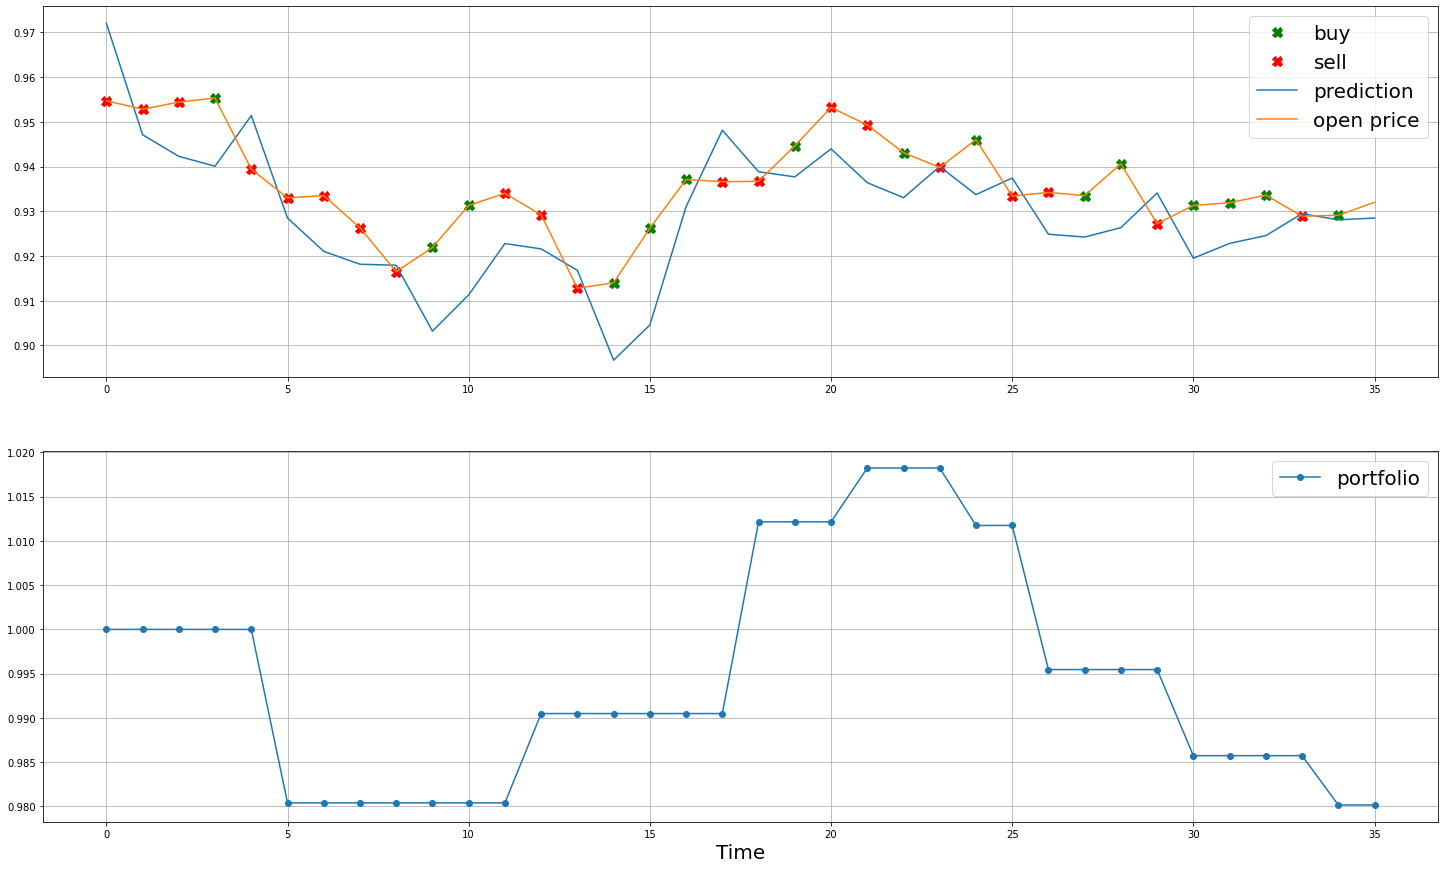

In [208]:
end = 40
label = outputs_gru_autoenc_17[:end-span]
p = price[l2+span+1:l2+end+1]
time = np.arange(len(label))

buy = []
buy_t = []
sell = []
sell_t = []

trade = False 
portfolio = 1
portfolio_list = [1]
usd = 0

#tax = 0.9985

for i in range(len(label)-1): 
  if label[i+1] > label[i]:

    if trade == False:
      portfolio -= 1
      usd += 1*tax/p[i]
      print("price = ", p[i], "[ TIME: ", i," ]")
      trade= True 


    buy.append(p[i])
    buy_t.append(i)
    
  else:
    if trade == True: 
      print("gain = ", (usd*p[i]*tax)-1,"%", "[ TIME: ", i," ]")
      portfolio += usd*p[i]*tax
      print("portfolio= ", portfolio)
      usd = 0
      trade= False
      print("-- -- -- -- -- -- -- -- -- -- -- -- -- -- ")


    sell.append(p[i])
    sell_t.append(i)

  if trade == False:  
    portfolio_list.append(portfolio)
  else:
    portfolio_list.append(portfolio+1)

plt.figure(figsize=(25, 15)) 

plt.subplot(2, 1, 1)
plt.plot(buy_t, buy,marker="X", markersize=10, linestyle = 'None',color='green', label='buy')
plt.plot(sell_t,sell,marker="X", markersize=10,linestyle = 'None',color='red', label='sell')
plt.plot(label, label="prediction")
plt.plot(time, p,label="open price")
plt.grid(True)
plt.legend(fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(time, portfolio_list,'o-',label="portfolio")
plt.grid(True)
plt.legend(fontsize=20)

plt.xlabel("Time", fontsize=20)
plt.show()

In [68]:
print(f"MSE GRU 1-feature:                             { REAL_MSE_gru_1: 0.08f}")
print(f"MSE GRU 5-features:                            { REAL_MSE_gru_5: 0.08f}")
print(f"MSE GRU Auto-Encoder 1-feature:                { REAL_MSE_gru_autoenc_1: 0.08f}")
print(f"MSE Dense latent space Auto-Encoder 1-feature: { REAL_MSE_dense_autoenc_1: 0.08f}")
print(f"MSE GRU Auto-Encoder 5-feature:                { REAL_MSE_gru_autoenc_5: 0.08f}")
print(f"MSE Dense latent space Auto-Encoder 5-feature: { REAL_MSE_dense_autoenc_5: 0.08f}")


MSE GRU 1-feature:                              0.00001621
MSE GRU 5-features:                             0.00001708
MSE GRU Auto-Encoder 1-feature:                 0.00001802
MSE Dense latent space Auto-Encoder 1-feature:  0.00001805
MSE GRU Auto-Encoder 5-feature:                 0.00002057
MSE Dense latent space Auto-Encoder 5-feature:  0.00001905


In [69]:
print(f"ACC GRU 1-feature:                             { REAL_ACC_gru_1: 0.08f}")
print(f"ACC GRU 5-features:                            { REAL_ACC_gru_5: 0.08f}")
print(f"ACC GRU Auto-Encoder 1-feature:                { REAL_ACC_gru_autoenc_1: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 1-feature: { REAL_ACC_dense_autoenc_1: 0.08f}")
print(f"ACC GRU Auto-Encoder 5-feature:                { REAL_ACC_gru_autoenc_5: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 5-feature: { REAL_ACC_dense_autoenc_5: 0.08f}")


ACC GRU 1-feature:                              0.48888889
ACC GRU 5-features:                             0.52000000
ACC GRU Auto-Encoder 1-feature:                 0.49629630
ACC Dense latent space Auto-Encoder 1-feature:  0.48888889
ACC GRU Auto-Encoder 5-feature:                 0.52000000
ACC Dense latent space Auto-Encoder 5-feature:  0.52444444


# TODO:

- check with norm and with out norm of output [OK]
- auto encode 1 & 2 add dense for with latent space prediction [OK]
- save_model_weight [OK]
- add trend NN (gru, AE, gru + AE, ... test in an other file)  
- add regression on output: x and x^2
- add aux block (gru, AE, gru + AE, ... test in an other file)
- accuracy score [OK]
 

### GRU (AUX block)

In [150]:
gru_model_aux = ml.ExchangeRateNet(num_layers=2)
gru_model_aux.to('cuda')
gru_model_aux

ExchangeRateNet(
  (gru_general): GRU_base(
    (gru): GRU(5, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_ex_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_SPI_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, t

In [151]:
train_loss, val_loss, aux_loss, aux_loss_val = pl.train_aux(gru_model_aux, train_x_norm, train_y_norm, val_x_norm, val_y_norm, batch_size_=512, num_epochs_=300, lr_=0.0001, device_='cuda')


 20%|██        | 60/300 [00:12<01:09,  3.45it/s]

Epoch: 60/300
MSE = [train loss mean :  1.09071247] , [val loss mean:  0.88043380, MSE (last) 80.89692%]
Aux loss train: [close:  0.87124 ], [SMI:  0.51552 ], [SP500:  0.60961 ], [bondCH:  1.71255 ] [bondUS:  0.55958 ] [Gru base:  1.23278]
Aux loss val:   [close:  0.60145 ], [SMI:  0.47238 ], [SP500:  0.50820 ], [bondCH:  1.37632 ] [bondUS:  0.58917 ] [Gru base:  0.98881]


 40%|████      | 121/300 [00:23<00:27,  6.61it/s]

Epoch: 120/300
MSE = [train loss mean :  0.96322591] , [val loss mean:  0.74294006, MSE (last) 68.49026%]
Aux loss train: [close:  0.72973 ], [SMI:  0.48102 ], [SP500:  0.51515 ], [bondCH:  0.80271 ] [bondUS:  0.47016 ] [Gru base:  0.78842]
Aux loss val:   [close:  0.52613 ], [SMI:  0.42970 ], [SP500:  0.38190 ], [bondCH:  0.71793 ] [bondUS:  0.45144 ] [Gru base:  0.60230]


 60%|██████    | 181/300 [00:33<00:18,  6.38it/s]

Epoch: 180/300
MSE = [train loss mean :  0.84823694] , [val loss mean:  0.62038877, MSE (last) 56.55461%]
Aux loss train: [close:  0.72774 ], [SMI:  0.48151 ], [SP500:  0.51386 ], [bondCH:  0.61696 ] [bondUS:  0.46271 ] [Gru base:  0.70226]
Aux loss val:   [close:  0.52272 ], [SMI:  0.43048 ], [SP500:  0.37792 ], [bondCH:  0.54410 ] [bondUS:  0.44456 ] [Gru base:  0.51780]


 80%|████████  | 241/300 [00:42<00:09,  6.52it/s]

Epoch: 240/300
MSE = [train loss mean :  0.75823382] , [val loss mean:  0.53470854, MSE (last) 51.67862%]
Aux loss train: [close:  0.73534 ], [SMI:  0.47997 ], [SP500:  0.50869 ], [bondCH:  0.58885 ] [bondUS:  0.45790 ] [Gru base:  0.69332]
Aux loss val:   [close:  0.52057 ], [SMI:  0.43176 ], [SP500:  0.37802 ], [bondCH:  0.51253 ] [bondUS:  0.44305 ] [Gru base:  0.51086]


100%|██████████| 300/300 [00:51<00:00,  5.81it/s]

Epoch: 300/300
MSE = [train loss mean :  0.70408128] , [val loss mean:  0.51219988, MSE (last) 51.01189%]
Aux loss train: [close:  0.72119 ], [SMI:  0.48061 ], [SP500:  0.50668 ], [bondCH:  0.57678 ] [bondUS:  0.45625 ] [Gru base:  0.66863]
Aux loss val:   [close:  0.52073 ], [SMI:  0.43227 ], [SP500:  0.37761 ], [bondCH:  0.51240 ] [bondUS:  0.44405 ] [Gru base:  0.51342]


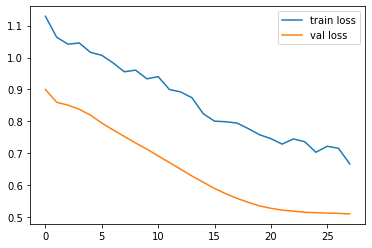

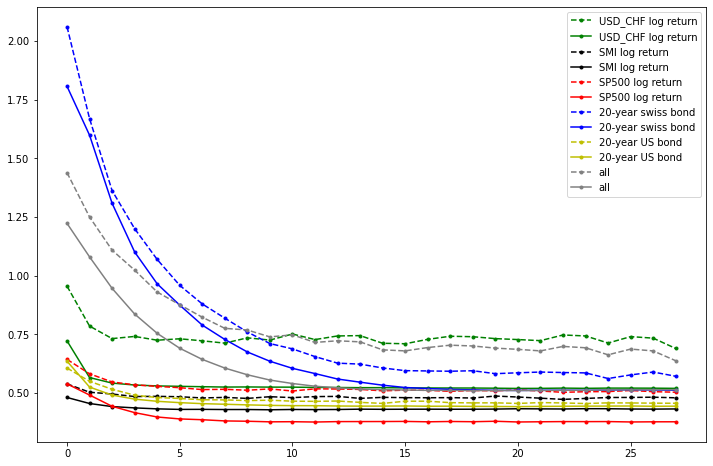

MSE: 56.435073545595834%
REAL MSE: 0.0017016591283277142
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.476e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:27:47   Log-Likelihood:                 2753.9
No. Observations:                 676   AIC:                            -5504.
Df Residuals:                     674   BIC:                            -5495.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

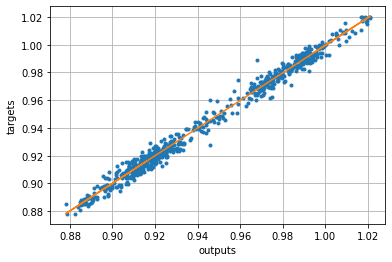

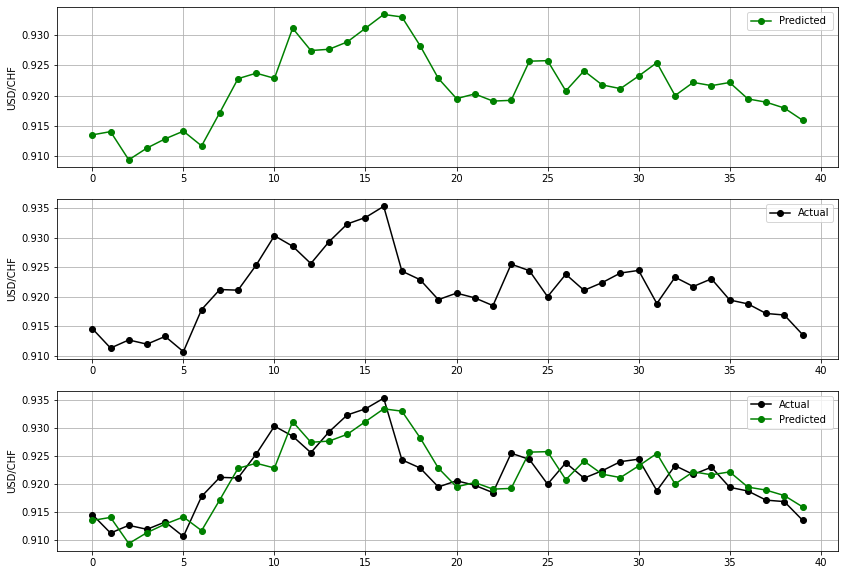

In [152]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 10)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 10)[1:] , label="val loss")
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
name  = ['USD_CHF log return','SMI log return', 'SP500 log return', '20-year swiss bond', '20-year US bond', 'all']
color= ['g', 'k', 'r', 'b', 'y', 'grey']
for i in range(len(aux_loss)): 
  plt.plot(pl.smooth_loss(aux_loss[i], chunksize = 10)[1:],'.--', label=name[i], c=color[i])
  plt.plot(pl.smooth_loss(aux_loss_val[i], chunksize = 10)[1:],'.-' ,label=name[i], c=color[i])
plt.legend()
plt.show()

outputs, targets, MSE = pl.evaluate_aux(gru_model_aux, test_x_norm, test_y_norm, device='cuda') 

min = test_x.min(axis=1)
max = test_x.max(axis=1)
o_aux = outputs.reshape(-1,)* (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((o_aux-t)**2)*100)

pl.regression_result(t,o_aux)

ds.plot_result_price(o_aux, t, nb=40)


# Result 

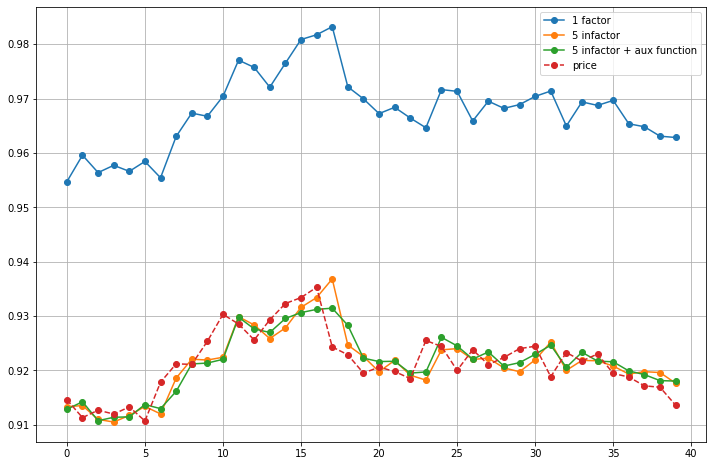

In [146]:
nb = 40
plt.figure(figsize=(12,8))
plt.plot(outputs_simple[-nb:],'o-', label="1 factor")
plt.plot(o[-nb:],'o-' , label="5 infactor")
plt.plot(o_aux[-nb:],'o-' , label="5 infactor + aux function")
plt.plot(t[-nb:],'o--', label="price")
plt.grid()
plt.legend()
plt.show()

#### Test for check normalisation...

In [ ]:
plt.plot(test_y[-40:,0])
plt.show()
min = test_x.min(axis=1)
max = test_x.max(axis=1)
plt.plot(test_y_norm[-40:,0] * (max[-40:,0] - min[-40:,0]) + min[-40:,0])
plt.show()
plt.plot(test_y_norm[-40:,0])